# Lidar pointcloud analysis using laserchicken

In this tutorial, we demonstrate an example of analysing AHN3 pointcloud data using the `laserchicken` package.

### The dataset

AHN (Actueel Hoogtebestand Nederland) is a digtal height dataset of the Netherlands, measured with laser altimetry. The [AHN3](https://www.pdok.nl/introductie/-/article/actueel-hoogtebestand-nederland-ahn3-) dataset, which is used in this tutorial, is the third update of this dataset. 

AHN3 is a public dataset and is free from copyright restrictions. Please refer to [this link](https://data.overheid.nl/en/dataset/11513-actueel-hoogtebestand-nederland-3--ahn3-) for the license status of AHN3.

In [6]:
import numpy as np
from matplotlib import pyplot as plt

To avoid the code duplication, we will write a small function `visualize_pc` to visualize the pointcloud later.

In [7]:
def visualize_pc(pc, col, npmax=20000, clabel=None, pointsize=3):
    """
    pc: input pointcloud
    col: data column to be visualized
    npmax: max number of points to visualize
    clable: colorbar lable
    pointsize: visualized point size 
    """
    fig, ax = plt.subplots()
    npoints = pc['vertex']['x']['data'].shape[0]
    if npoints>npmax: # vilsualize up to npmax points
        idx=np.random.choice(range(npoints),npmax)
        x = pc['vertex']['x']['data'][idx]
        y = pc['vertex']['y']['data'][idx]
        data = pc['vertex'][col]['data'][idx]
    else:
        x = pc['vertex']['x']['data']
        y = pc['vertex']['y']['data']
        data = pc['vertex'][col]['data']
    sc = ax.scatter(x, y, c = data, s = pointsize)
    ax.grid()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('RD x [m]')
    ax.set_ylabel('RD y [m]')
    fig.colorbar(sc, label=clabel)
    plt.show()

### Pointcloud analysis using `laserchicken`

After the preparation job, we can start the data analysis with laserchicken. In this tutorial, our goal is to analyze the vegetation height distribution of an example area. First we will load in the raw pointcloud data, and viualize the height for a general overview.

Total number of points: 394473


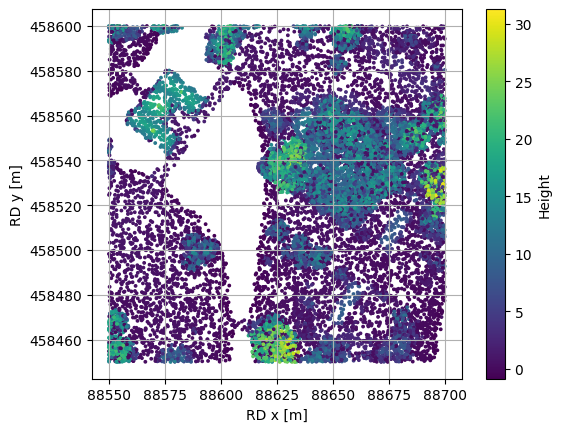

In [8]:
from laserchicken import load
pc = load('../data/AHN3.las')
print("Total number of points: {}".format(pc['vertex']['x']['data'].shape[0]))
visualize_pc(pc, col='z', clabel='Height', npmax = 20000) # only visualize 20000 points

Due to the large number of points, we only visulized randomly selected 20000 points out of 394473 points. From the location and heights of the points we can tell this is an area with a mix of vegetation, build-ups (e.g. the building and bridge at the North-West) and waterbody (the white region).

First of all, we would like to crop the data to the actual area of interest. This can be done by cropping with a bounding box.

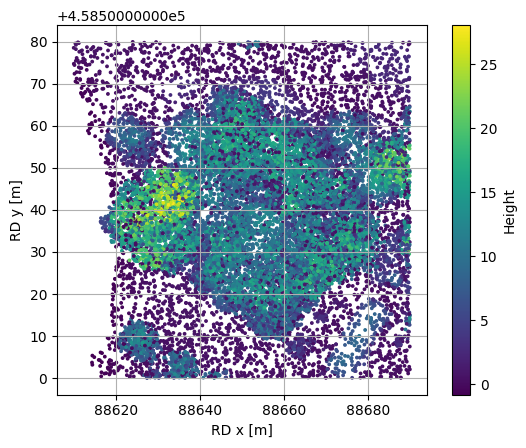

In [9]:
from laserchicken.filter import select_polygon

# Define a croping
west = 88610
east = 88690
south = 458500
north = 458580
polygon = "POLYGON(( {w} {s}, {e} {s}, {e} {n}, {w} {n}, {w} {s}))".format(w=west, e=east, n=north, s=south)

pc = select_polygon(pc, polygon)
visualize_pc(pc, col='z', clabel='Height')

Since AHN3 uses a absolute height reference system, so the height values are also absolute. However, in our case, we are more interested in the local height of the vegetation. Therefore, we will normalize the height to the local minimum height.

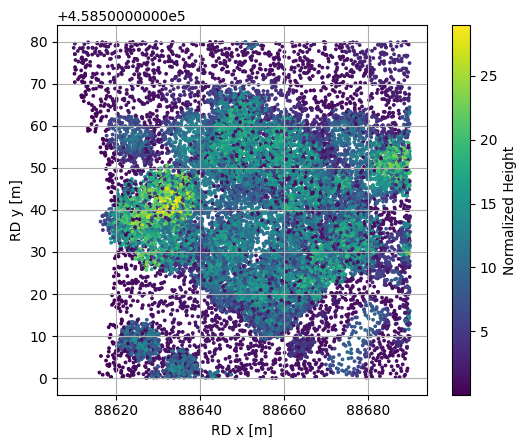

In [10]:
from laserchicken.normalize import normalize
pc = normalize(pc)
visualize_pc(pc, col='normalized_height', clabel='Normalized Height')

Our goal is to understand the statistics of the pointcloud in some certain clusters. To do this, we will create a virtual pointcloud know as the "target points". These points evenly distributed in the horizontal space with a given density. The statistics will be agregated to the target points.  

In [11]:
from laserchicken import keys

# Resolution of the target pointcloud, in meter
resolution = 0.5

# Define the grid system 
x = np.arange(west, east, resolution) + resolution/2.
y = np.arange(south, north, resolution) + resolution/2.
xv, yv = np.meshgrid(x, y)

# Genrate target pointcloud
targets = {keys.point: {'x': {'type': 'float64', 'data': xv.flatten()},
                        'y': {'type': 'float64', 'data': yv.flatten()},
                        'z': {'type': 'float64', 'data': np.zeros_like(xv.flatten())}},
           keys.point_cloud: {},
           keys.provenance: []}

After the target pointcloud is made, the statistics will be aggregated to the target point. The aggregation per target point is performed with a given searching volume, which has a customizable shape and size. Here we use the "cell" volume with the size of target pointcloud resolution. 


In [12]:
from laserchicken import build_volume

volume = build_volume("cell", side_length=resolution)
volume

Per target point, we first find the neighboring points from the orihinal point cloud within the given aggragation volum. Then we compute the statistics of interest. Here we compute the "mean normalized height", which will be added as a feature to the target pointcloud.

Cylinder size in Bytes: 41016633.68526835
Memory size in Bytes: 8227647488
Start tree creation
Done with env tree creation
Done with target tree creation
Extracting feature(s) "['mean_normalized_height', 'std_normalized_height', 'coeff_var_normalized_height']"Extracting feature(s) "['mean_normalized_height', 'std_normalized_height', 'coeff_var_normalized_height']" took 1.87 seconds
The following unrequested features were calculated as a side effect, but will not be returned: ['coeff_var_normalized_height', 'std_normalized_height']


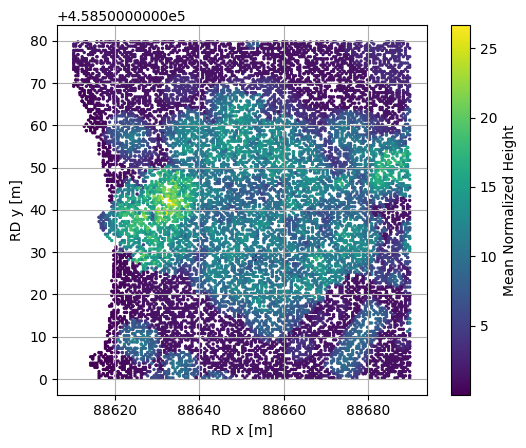

In [13]:
from laserchicken import compute_neighborhoods, compute_features

neighborhoods = compute_neighborhoods(pc, targets, volume)
compute_features(pc, neighborhoods, targets, ['mean_normalized_height'], volume)
visualize_pc(targets, col='mean_normalized_height', clabel='Mean Normalized Height', pointsize=2)

There are various of build-in features extractors in `laserchicken`. You can find them by:

In [14]:
from laserchicken.feature_extractor.feature_extraction import list_feature_names
sorted(list_feature_names())

['band_ratio_1<normalized_height<2',
 'band_ratio_2<normalized_height<3',
 'band_ratio_3<normalized_height',
 'band_ratio_normalized_height<1',
 'coeff_var_intensity',
 'coeff_var_normalized_height',
 'coeff_var_z',
 'density_absolute_mean_normalized_height',
 'density_absolute_mean_z',
 'echo_ratio',
 'eigenv_1',
 'eigenv_2',
 'eigenv_3',
 'entropy_normalized_height',
 'entropy_z',
 'kurto_normalized_height',
 'kurto_z',
 'max_intensity',
 'max_normalized_height',
 'max_z',
 'mean_intensity',
 'mean_normalized_height',
 'mean_z',
 'median_normalized_height',
 'median_z',
 'min_intensity',
 'min_normalized_height',
 'min_z',
 'normal_vector_1',
 'normal_vector_2',
 'normal_vector_3',
 'perc_100_normalized_height',
 'perc_100_z',
 'perc_10_normalized_height',
 'perc_10_z',
 'perc_11_normalized_height',
 'perc_11_z',
 'perc_12_normalized_height',
 'perc_12_z',
 'perc_13_normalized_height',
 'perc_13_z',
 'perc_14_normalized_height',
 'perc_14_z',
 'perc_15_normalized_height',
 'perc_15_z

`laserchicken` also supports self defined feature extractor. Below is an example of a self-defined feature extractor which computes the ratio of points within the volumn with height >10m.

Cylinder size in Bytes: 41016633.68526835
Memory size in Bytes: 8227647488
Start tree creation
Done with env tree creation
Done with target tree creation
Extracting feature(s) "['band_ratio_10<normalized_height']"Extracting feature(s) "['band_ratio_10<normalized_height']" took 0.58 seconds


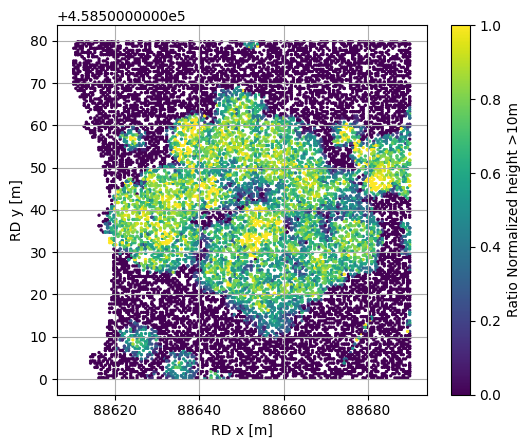

In [15]:
from laserchicken import register_new_feature_extractor
from laserchicken.feature_extractor.band_ratio_feature_extractor import BandRatioFeatureExtractor
register_new_feature_extractor(BandRatioFeatureExtractor(10,None,data_key='normalized_height'))

volume = build_volume("cell", side_length=resolution)
neighborhoods = compute_neighborhoods(pc, targets, volume)
compute_features(pc, neighborhoods, targets, ['band_ratio_10<normalized_height'], volume)
visualize_pc(targets, col='band_ratio_10<normalized_height', clabel='Ratio Normalized height >10m', pointsize=2)

The results can be exported to the disk.

In [16]:
from laserchicken import export
export(targets, 'my_output.ply')